## instalar libreria

In [2]:
!git clone https://github.com/juan-oviedo/Adaptacion-de-textos-para-aprendizaje-de-ingles-como-lengua-extranjera.git
!pip install /content/Adaptacion-de-textos-para-aprendizaje-de-ingles-como-lengua-extranjera/fkgl
!pip install sacremoses
!pip install bert-score

Cloning into 'Adaptacion-de-textos-para-aprendizaje-de-ingles-como-lengua-extranjera'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 54 (delta 17), reused 37 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (54/54), 40.05 KiB | 5.00 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Processing ./Adaptacion-de-textos-para-aprendizaje-de-ingles-como-lengua-extranjera/fkgl
  Preparing metadata (setup.py) ... done
  Created wheel for FKGL: filename=FKGL-0.1.0-py3-none-any.whl size=3749 sha256=3fbcb047503757c15f37829b0ec212e94c098c3eb13b8762869cb32bc4634952
  Stored in directory: /tmp/pip-ephem-wheel-cache-91pr023y/wheels/4c/b2/2c/8b4a6b85082c9c108aa224e72a2a089d2fdb8b0c327a0f5a45
Successfully built FKGL
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.9 MB/s eta 0:00:00


## imports

In [3]:
import nltk
nltk.download('punkt_tab')
import sklearn.metrics as sk_metrics
import sklearn.model_selection as sk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import numpy as np
import csv
import os
import collections
from google.colab import files
from google.colab import drive
from FKGL.fkgl import FKGLScorer
from bert_score import score
import torch

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## parametros

In [4]:
#nombre_archivo = "resultados_llama"
carpeta = "adaptacion"

folder_name = "mineria de datos/resultados/"
exp_min = 0
exp_max = 11
cantidad_experimentos = 2

## Cargar Textos originales

In [5]:
# Check if the zip file is present and has been unzipped
if not os.path.exists("cefr-levelled-english-texts.zip"):
    # Download the dataset if the zip file is not present
    !kaggle datasets download -d amontgomerie/cefr-levelled-english-texts

if not os.path.exists("cefr_leveled_texts.csv"):  # Adjust this to match the folder name after unzipping
    # Unzip the file if the unzipped folder does not exist
    !unzip cefr-levelled-english-texts.zip

Dataset URL: https://www.kaggle.com/datasets/amontgomerie/cefr-levelled-english-texts
License(s): CC0-1.0
 73% 1.00M/1.36M [00:01<00:00, 1.05MB/s]
100% 1.36M/1.36M [00:01<00:00, 1.32MB/s]
Archive:  cefr-levelled-english-texts.zip
  inflating: cefr_leveled_texts.csv  


In [6]:
# Load the CSV file into a DataFrame
df = pd.read_csv('cefr_leveled_texts.csv')

# Get the minimum number of samples in any class
min_samples = df['label'].value_counts().min()

# Downsample each class to have the same number of samples as the smallest class
df_balanced = df.groupby('label').apply(lambda x: x.sample(n=min_samples, random_state=60)).reset_index(drop=True)

distribution = df_balanced['label'].value_counts()
train, div = sk.train_test_split(df_balanced, test_size=0.2, random_state=70)
dev, holdout = sk.train_test_split(div, test_size=0.5, random_state=50)

train = train.reset_index(drop=True)
dev = dev.reset_index(drop=True)
holdout = holdout.reset_index(drop=True)

<ipython-input-6-fc31009e116c>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('label').apply(lambda x: x.sample(n=min_samples, random_state=60)).reset_index(drop=True)


In [7]:
true_list = pd.concat([dev, train])
true_labels = true_list['label'].tolist()
true_texts = true_list['text'].tolist()
dataframetext = pd.DataFrame({'text': true_list['text'].tolist()})

## carga de los experimentos

In [9]:
drive.mount('/content/drive', force_remount=False)
folder_root = "/content/drive/My Drive/"

Mounted at /content/drive


In [10]:
file_path = os.path.join(folder_root, folder_name, carpeta)

adapted_list = []
for i in range (exp_min, exp_max + 1):
  file_name= file_path + f"/experimento_adaptacion_{i}.csv"
  df = pd.read_csv(file_name)
  adapted_texts = df['Adaptacion'].tolist()
  adapted_list.append(adapted_texts)

## filtrado de adaptaciones

In [11]:
# Map CEFR levels to numerical values
cefr_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}

lista_0 = []
lista_1 = []
lista_2 = []
lista_3 = []
lista_4 = []
lista_5 = []
lista_6 = []
lista_7 = []
lista_8 = []
lista_9 = []
lista_10 = []
lista_11 = []
lista_org_0 = []
lista_org_1 = []
lista_org_2 = []
lista_org_3 = []
lista_org_4 = []
lista_org_5 = []
lista_org_6 = []
lista_org_7 = []
lista_org_8 = []
lista_org_9 = []
lista_org_10 = []
lista_org_11 = []

for indice in range(len(true_labels)):
  original_level = true_labels[indice]
  original_index  = cefr_mapping[original_level]
  valid_indices = range(max(0, original_index - 2), min(6, original_index + 3))

  for i in range (0, 6):
    if i in valid_indices:
      if i == 0:
        lista_0.append(adapted_list[i][indice])
        lista_6.append(adapted_list[i + 6][indice])

        lista_org_0.append(true_texts[indice])
        lista_org_6.append(true_texts[indice])

      elif i == 1:
        lista_1.append(adapted_list[i][indice])
        lista_7.append(adapted_list[i + 6][indice])

        lista_org_1.append(true_texts[indice])
        lista_org_7.append(true_texts[indice])

      elif i == 2:
        lista_2.append(adapted_list[i][indice])
        lista_8.append(adapted_list[i + 6][indice])

        lista_org_2.append(true_texts[indice])
        lista_org_8.append(true_texts[indice])

      elif i == 3:
        lista_3.append(adapted_list[i][indice])
        lista_9.append(adapted_list[i + 6][indice])

        lista_org_3.append(true_texts[indice])
        lista_org_9.append(true_texts[indice])

      elif i == 4:
        lista_4.append(adapted_list[i][indice])
        lista_10.append(adapted_list[i + 6][indice])

        lista_org_4.append(true_texts[indice])
        lista_org_10.append(true_texts[indice])

      else:
        lista_5.append(adapted_list[i][indice])
        lista_11.append(adapted_list[i + 6][indice])

        lista_org_5.append(true_texts[indice])
        lista_org_11.append(true_texts[indice])


lista_textos_adaptados_filtrados = [lista_0, lista_1, lista_2, lista_3, lista_4, lista_5, lista_6, lista_7, lista_8, lista_9, lista_10, lista_11]
lista_textos_originales_filtrados = [lista_org_0, lista_org_1, lista_org_2, lista_org_3, lista_org_4, lista_org_5, lista_org_6, lista_org_7, lista_org_8, lista_org_9, lista_org_10, lista_org_11]

## Calcular FKGL

In [ ]:
true_texts[207] = ""
true_texts[678] = ""
true_texts[800] = ""

In [ ]:
#ORIGINAL

flesch = []
for text in true_texts:
    scorer = FKGLScorer()
    scorer.add(text)
    score = scorer.score()
    flesch.append(score)

In [ ]:
#FILTRADO

flesch_adapted_filtered = []
for i in range(len(lista_textos_adaptados_filtrados)):
  adapted_texts = lista_textos_adaptados_filtrados[i]
  flesch_exp = []

  j = 0
  for text in adapted_texts:
    scorer = FKGLScorer()
    scorer.add(text)
    score = scorer.score()
    flesch_exp.append(score)
    if j <= 10:
      print ("--------------------------------------------------------------------------------------------------")
      print("experimento: ", i, "score: ", score)
      print(text)
    j += 1

  flesch_adapted_filtered.append(flesch_exp)

--------------------------------------------------------------------------------------------------
experimento:  0 score:  0
What is the teacher doing?
She is calling the roll.

What does it mean?
It means she is counting the students.

What should I do?
When she calls your name, say "yes".
--------------------------------------------------------------------------------------------------
experimento:  0 score:  2.3218481317798343
A man crashed his car into a bus with the Dutch royal family inside. He died.

A car went into a crowd waiting for the royal family in a town called Apeldoorn. The man was very hurt. He died on Friday.

The man was trying to hurt the royal family. He was in a car with him alone. The car was badly damaged.

Many people were hurt in the crash. Five people died. The royal family was very scared.

The royal family was on a bus. They were going to see people in a town. A car came and hit a barrier. The car was badly damaged.

The royal family was very scared. They 

In [ ]:
flesch_df = pd.DataFrame({'flesch': flesch, 'true_labels': true_labels})

## Plots

### Hacer Plot filtrado

In [ ]:
label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}

values_adapted_filtered = []
for i in range(len(flesch_adapted_filtered)):
  labels_list = [label_mapping[i % 6]] * len(flesch_adapted_filtered[i])
  values_adapted_filtered.append(labels_list)

In [ ]:
#FILTRADO

lista_de_dataframe_filtered = []
for i in range (cantidad_experimentos):
  lista_de_valores = []
  lista_de_labels = []
  for j in range (6 * i, 6*(i+1)):
    lista_de_valores = lista_de_valores + flesch_adapted_filtered[j]
    lista_de_labels = lista_de_labels + values_adapted_filtered[j]

  dataframe = pd.DataFrame({'flesch': lista_de_valores, 'true_labels': lista_de_labels})
  lista_de_dataframe_filtered.append(dataframe)

experiment:  0 averege:  1.36698442807693
experiment:  1 averege:  2.2474232438050223
experiment:  2 averege:  5.871724776544803
experiment:  3 averege:  11.43682406621778
experiment:  4 averege:  14.740137870320737
experiment:  5 averege:  16.164549872673614
experiment:  6 averege:  1.5079599110484683
experiment:  7 averege:  2.5463023154654447
experiment:  8 averege:  5.63445436929612
experiment:  9 averege:  10.669263970996145
experiment:  10 averege:  14.167268898204568
experiment:  11 averege:  15.361853481682022


     flesch true_labels
0  0.000000          A1
1  2.321848          A1
2  2.890922          A1
3  1.126190          A1
4  0.000000          A1


<ipython-input-54-bad8aa4e6a90>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=flesch_df, x='true_labels', y='flesch', palette='viridis', order=order)


Plot saved to /content/drive/My Drive/mineria de datos/resultados/adaptacion/fkgl_adaptado_filtrado_0.png


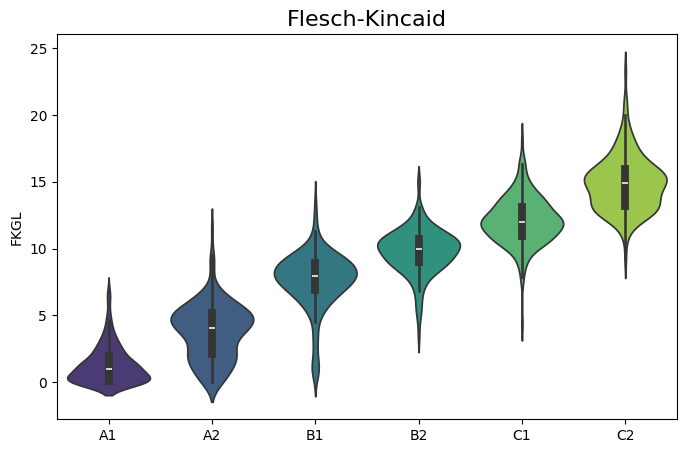

     flesch true_labels
0  2.483333          A1
1  2.619018          A1
2  3.081286          A1
3  1.653364          A1
4  0.000000          A1


<ipython-input-54-bad8aa4e6a90>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=flesch_df, x='true_labels', y='flesch', palette='viridis', order=order)


Plot saved to /content/drive/My Drive/mineria de datos/resultados/adaptacion/fkgl_adaptado_filtrado_1.png


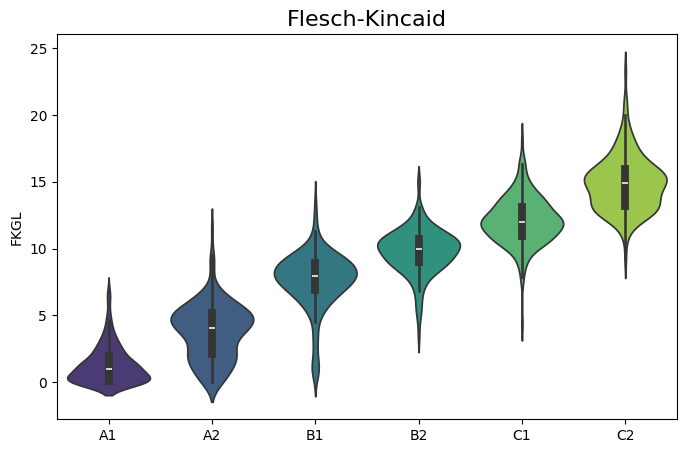

In [ ]:
for i in range (cantidad_experimentos):
  dataframe = lista_de_dataframe_filtered[i]
  # Plotting
  plt.figure(figsize=(8, 5))
  sns.violinplot(data=flesch_df, x='true_labels', y='flesch', palette='viridis', order=order)

  # Customize plot
  plt.title('Flesch-Kincaid', fontsize=16)
  plt.xlabel('')
  plt.ylabel('FKGL')

  path =file_path + f'/fkgl_adaptado_filtrado_{i}.png'  # Change path as needed
  plt.savefig(path, dpi=600)
  print(f"Plot saved to {path}")

  plt.show()

### Hacer plot original

<ipython-input-39-8d5c59bb863c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=flesch_df, x='true_labels', y='flesch', palette='viridis', order=order)


Plot saved to /content/drive/My Drive/mineria de datos/resultados/adaptacion/fkgl_original.png


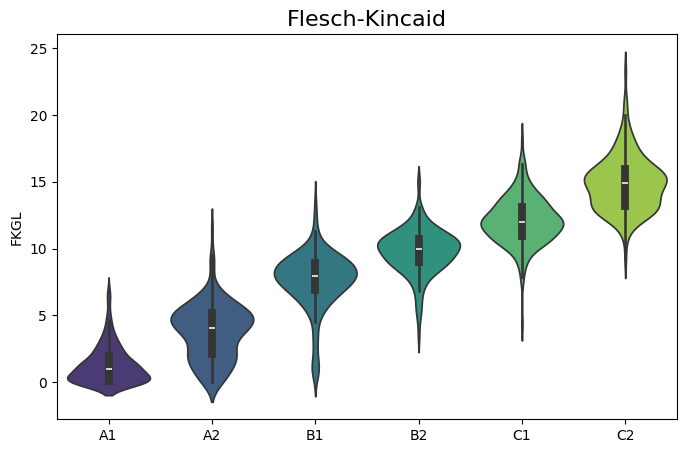

In [ ]:
# Define the desired order for CEFR levels
order = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']

# Plotting
plt.figure(figsize=(8, 5))
sns.violinplot(data=flesch_df, x='true_labels', y='flesch', palette='viridis', order=order)

# Customize plot
plt.title('Flesch-Kincaid', fontsize=16)
plt.xlabel('')
plt.ylabel('FKGL')


path =file_path + f'/fkgl_original.png'  # Change path as needed
plt.savefig(path, dpi=600)
print(f"Plot saved to {path}")

plt.show()

## Metricas sobre fkgl

### Calcular average original por clase

In [ ]:
average_original = []
for i in range(6):
  sum = 0
  count = 0
  for idx, label in enumerate(true_labels):  # Iterate over the list
    if label_mapping[i] == label:
      sum += flesch[idx]
      count += 1
  average_original.append(sum/count)

In [ ]:
print(average_original)

[1.276045193330179, 3.80714779155808, 7.61338640364493, 9.793464788150393, 12.103422121390603, 14.875717431789752]


### calcular average adaptado filtrado por clase

In [1]:
average_adapted_all_experiment_filtered = []
for i in range (cantidad_experimentos):

  average_adapted = []
  for j in range(6 * i, 6*(i+1)):
    avg = np.mean(flesch_adapted_filtered[j])
    average_adapted.append(avg)

  average_adapted_all_experiment_filtered.append(average_adapted)

NameError: name 'cantidad_experimentos' is not defined

In [ ]:
print(average_adapted_all_experiment_filtered)

[[1.36698442807693, 2.2474232438050223, 5.871724776544803, 11.43682406621778, 14.740137870320737, 16.164549872673614], [1.5079599110484683, 2.5463023154654447, 5.63445436929612, 10.669263970996145, 14.167268898204568, 15.361853481682022]]


### Diferencia absoluta con original

In [ ]:
lista_de_diff = []
for i in range (cantidad_experimentos):
  suma = 0
  for j in range(6):
    error = (average_adapted_all_experiment_filtered[i][j] - average_original[j])**2
    suma += error
  lista_de_diff.append(suma)

In [ ]:
print(lista_de_diff)

[4.460326955629523, 4.707776149014067, 16.788384550733884, 10.82250373329308]


## Metricas bertscore

### Realizar metricas y guardarlas

In [ ]:
if torch.cuda.is_available():
  device="cuda"
else:
  device="cpu"

resultados_bert = []
for i in range (len(lista_textos_adaptados_filtrados)):
  B = lista_textos_adaptados_filtrados[i]
  A = lista_textos_originales_filtrados[i]
  if len(A) != len(B):
    raise ValueError("Both lists must have the same number of elements.")

  # Calculate BERTScore
  P, R, F1 = score(B, A, lang="en", device=device, verbose=True)  # B is compared to A
  resultados_bert.append((P, R, F1))

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/18 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/9 [00:00<?, ?it/s]

done in 40.30 seconds, 13.52 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/23 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/12 [00:00<?, ?it/s]

done in 63.14 seconds, 11.53 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/29 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/15 [00:00<?, ?it/s]

done in 99.59 seconds, 9.18 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/29 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/15 [00:00<?, ?it/s]

done in 125.66 seconds, 7.21 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/23 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/12 [00:00<?, ?it/s]

done in 103.43 seconds, 7.08 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/18 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/9 [00:00<?, ?it/s]

done in 79.00 seconds, 6.90 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/18 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/9 [00:00<?, ?it/s]

done in 45.35 seconds, 12.02 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/23 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/12 [00:00<?, ?it/s]

done in 64.67 seconds, 11.26 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/29 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/15 [00:00<?, ?it/s]

done in 96.14 seconds, 9.51 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/29 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/15 [00:00<?, ?it/s]

done in 113.85 seconds, 7.96 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/23 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/12 [00:00<?, ?it/s]

done in 101.10 seconds, 7.24 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/18 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/9 [00:00<?, ?it/s]

done in 78.25 seconds, 6.96 sentences/sec


In [ ]:
for i in range (len(lista_textos_adaptados_filtrados)):
  P, R, F1 = resultados_bert[i]
  # Prepare data for saving
  results = {
      "Precision": P.tolist(),
      "Recall": R.tolist(),
      "F1 Score": F1.tolist()
  }

  # Convert to DataFrame
  df = pd.DataFrame(results)

  # Save to CSV
  path = file_path + f"/bertscore_results_{i}.csv"
  df.to_csv(path, index=False)

  print(f"Results saved to {path}")

Results saved to /content/drive/My Drive/mineria de datos/resultados/adaptacion/bertscore_results_0.csv
Results saved to /content/drive/My Drive/mineria de datos/resultados/adaptacion/bertscore_results_1.csv
Results saved to /content/drive/My Drive/mineria de datos/resultados/adaptacion/bertscore_results_2.csv
Results saved to /content/drive/My Drive/mineria de datos/resultados/adaptacion/bertscore_results_3.csv
Results saved to /content/drive/My Drive/mineria de datos/resultados/adaptacion/bertscore_results_4.csv
Results saved to /content/drive/My Drive/mineria de datos/resultados/adaptacion/bertscore_results_5.csv
Results saved to /content/drive/My Drive/mineria de datos/resultados/adaptacion/bertscore_results_6.csv
Results saved to /content/drive/My Drive/mineria de datos/resultados/adaptacion/bertscore_results_7.csv
Results saved to /content/drive/My Drive/mineria de datos/resultados/adaptacion/bertscore_results_8.csv
Results saved to /content/drive/My Drive/mineria de datos/result

### Cargar resultados

In [12]:
file_path = os.path.join(folder_root, folder_name, carpeta)

precision_list = []
recall_list = []
f1_score_list = []

for i in range (exp_min, exp_max + 1):
  file_name= file_path + f"/bertscore_results_{i}.csv"
  df = pd.read_csv(file_name)
  # Extract metrics
  precision_list.append(df['Precision'].tolist())
  recall_list.append(df['Recall'].tolist())
  f1_score_list.append(df['F1 Score'].tolist())

### Calcular average

In [13]:
precision_average_list = []
recall_average_list = []
f1_score_average_list = []
for i in range (cantidad_experimentos):

  precision_average = []
  recall_average = []
  f1_score_average = []
  for j in range(6 * i, 6*(i+1)):
    p_avg = np.mean(precision_list[j])
    r_avg = np.mean(recall_list[j])
    f1_avg = np.mean(f1_score_list[j])
    precision_average.append(p_avg)
    recall_average.append(r_avg)
    f1_score_average.append(f1_avg)

  precision_average_list.append(precision_average)
  recall_average_list.append(recall_average)
  f1_score_average_list.append(f1_score_average)

In [14]:
print(precision_average_list)
print(recall_average_list)
print(f1_score_average_list)

[[0.9195977633152533, 0.9211107191148695, 0.9318579316660924, 0.9182427224207661, 0.9118957807783221, 0.9075708153050974], [0.9150584084178329, 0.9167494851645532, 0.9210072821026558, 0.9121370849098854, 0.9074652523128062, 0.9085253539435361]]
[[0.8925402010252717, 0.8941984201198095, 0.9209612178202531, 0.9125948547659067, 0.9112810252305589, 0.9068821060548135], [0.8934976256221806, 0.8952625766396523, 0.9084541722643036, 0.902330383559726, 0.9036613581447653, 0.9042979516020608]]
[[0.9057569548624371, 0.9073665670149929, 0.9263053722924164, 0.9153473639067172, 0.9115463566910373, 0.9071897281419247], [0.9039711347413719, 0.9057553808440219, 0.9145700482231783, 0.9071254718382626, 0.9054949444825532, 0.906360875794647]]


In [15]:
#average of the average
precision_average_all_experiment = []
recall_average_all_experiment = []
f1_score_average_all_experiment = []

for i in range (cantidad_experimentos):
  p_avg = np.mean(precision_average_list[i])
  r_avg = np.mean(recall_average_list[i])
  f1_avg = np.mean(f1_score_average_list[i])
  precision_average_all_experiment.append(p_avg)
  recall_average_all_experiment.append(r_avg)
  f1_score_average_all_experiment.append(f1_avg)

In [16]:
print(precision_average_all_experiment)
print(recall_average_all_experiment)
print(f1_score_average_all_experiment)

[0.9183792887667336, 0.913490477808545]
[0.9064096375027689, 0.9012506779721147]
[0.9122520571515875, 0.9072129759873392]
